<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/ResNet50(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

# 패키지 불러오기

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 5.7 MB/s 
     |████████████████████████████████| 37.1 MB 96 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# import
import numpy as np
import pandas as pd
import os
import sklearn 
import tensorflow as tf
from tensorflow.keras.layers import Input , Conv2D  ,ReLU, MaxPooling2D,  BatchNormalization,  Dense, Dropout , Flatten, Softmax, ZeroPadding2D, add, Add,  Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import SGD
import albumentations as A
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping 



# ResNet 논문 분석


* ResNet의 가장 중요한 특징은 residual block이다. 
    * 신경망이 깊어질 수록 어느 순간부터 degradation 문제가 발생한다. 이는 모델의 정확도가 좋아지다가 어느순간부터 정체되고, 더 나아가서 성능이 나빠지는 현상이다. 
    * 이는 overfeating과 다른 것이 train 에러와, val 에러가 모두 커지기 때문이다. 오버피팅문제였다면 train 에러는 개선되어야한다.
    * 논문에서 원인을 명백하게 밝히지 않았으며, 실험결과 18레이어보다 34레이어의 에러가 큰 것은 gradient vanishing 문제가 아니라고 밝히고 있다. 또한 이 문제의 자세한 것은 추후의 연구에 맡긴다고 적혀있다.
    * 중요한 것은 degradation 이 residual block 이라는 아이디어로 어느 정도 해결 될 수 있다는 것.
    * residual mapping이 아이디어는 identity mapping에서 출발. 극단적인 가정으로 '층이 깊어지지만 그 층들이 identity mapping이라면 최소한 나빠지지는 않을 것이다. ' 라는 생각에서 출발. 근데, 실제로 학습을 identity mapping 처럼하는 과정은 너무나 unable to do so in feasible time이다. 따라어 이 논문에서는 resnet framework를 제안함. 이는 레이어가 underlying mapping을 학습하는 것이 아닌 residual mapping에 맞춰 학습하게 함.

            *개인적으로 이 부분에서 underlying mapping 즉, identity 맵핑을 직접학습하는게 어려우니까 잔차를 0으로 학습하게 만든다는 생각으로 블럭을 만들었다고 생각함.
    * 극단적으로 함수의 최적이 identity 라고 가정하면, residual을 zero로 만드는 것이 nonlinear 층들을 identity로 만드는 것보다 훨씬 쉬울 것임.
    * 따라서 F(x) + x 에서 F(x)를 학습시키기위해 x라는 shortcut connection을 추가함.

            자세한 내용은 너무 길어질 것 같아서 핵심내용인 위 부분만 적고 구현에 대해 적자면


* ResNet 구현 관련 이슈

    * 구조는 아래와 같다.
    * **내가 구현할 50층 이상의 deep한 놈은 단순히 shortcut만 추가하는 것이 아니라, 1x1 conv를 이용해 채널을 압축하고 3x3 이후 다시 1x1로 사이즈를 맞춰주는 bottleneck 구조가 필요하다.** 이는 정보를 압축하는 대신 계산량을 줄여준다. 이 부분 구현이 조금 까다로울 듯.
    * resnet50은 블럭 단위로 3/4/6/3의 conv세트를 구성하는게 
    * feature map의 크기를 자를 때 이전의 모델과 달리 pooling 말고 stride 2를 해서 잘라버림. resnet 기준으로 이 후 pooling 보다 stride가 많이 쓰임
    * 피쳐맵 크기는 절반 depth는 두배로

* 그 외의 디테일
    * decay = 0.0001, momentum 0.9
    * learing rate 초기값 = 0.1 이후 1/10씩 감소
    * dropout 하지 않음
    * crop은 모서리에서 10번 , 중앙부 2번 총 10번 진행
    * he initialization
    * 이번 구현은 블락 구현이 핵심이므로 세세한 부분, 가령 augmentation 등등은 논문 그대로를 따라가지 않겠음.


* 여기서 헷갈릴 수 있는 내용. 
    * 아래 그림에서 256채널이 들어와서 1/4로 차원 축소해서 계산량을 줄여서 3x3 conv을 한다음 다시 256채널로 늘린다. 첫번째 블락만 독특하게 64개를 받아서 256개로 바꿈. 이 때, 헷갈리는게 첫 블럭의 ishortcut부분 또한 사이즈를 조절해서 256개로 늘려서 더해줘야 차원이 맞음.
    * 또한 더해지는 값은 채널을 concate하는게 아니라 add하는 것이므로 resblock의 채널은 유지된다.


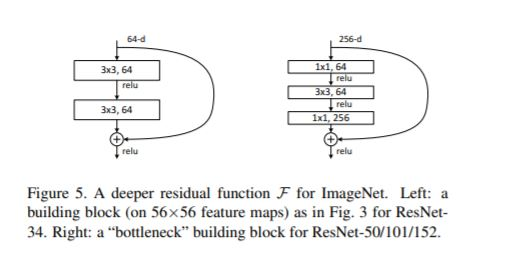

---
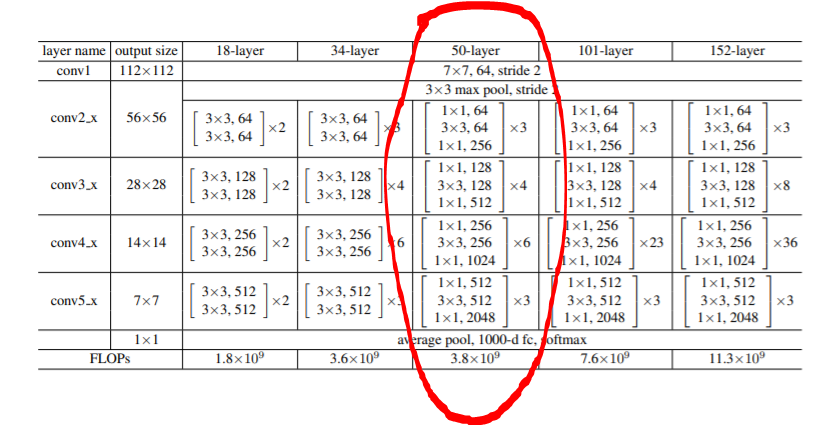

---
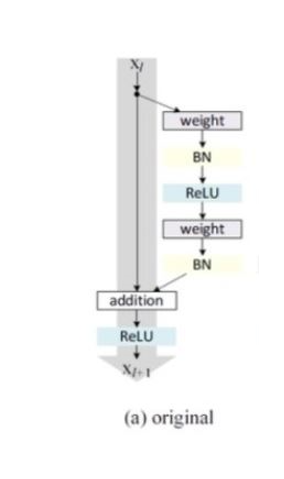



# ResNet50 구현

## bottle neck 구조 블럭 구현
res_block, res_block_stride 구현

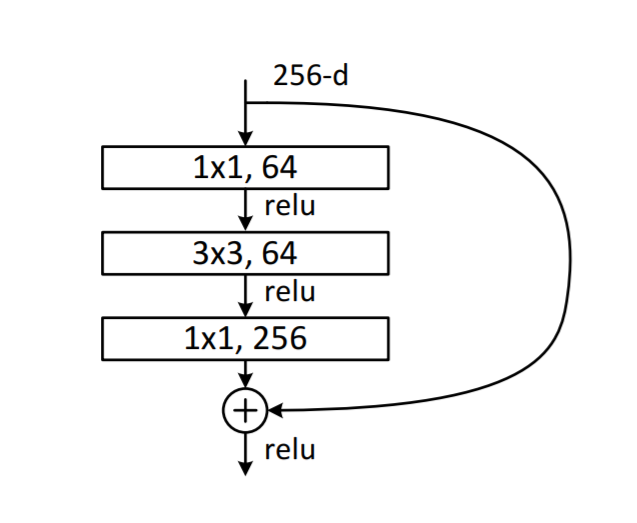

In [ ]:
def res_block(input_tensor, filters):
    # 필터 수를 리스트로 받음
    filter1, filter2, filter3 = filters

    # 필터1
    x = Conv2D(filters=filter1, kernel_size=(1, 1), kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 필터2
    x = Conv2D(filters=filter2, kernel_size=(3, 3), padding= 'same' ,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 필터3
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # shortcut과 합치기
    x = Add()([input_tensor, x])
    x = ReLU()(x)
    return x

In [ ]:
def res_block_stride2(input_tensor, filters, strides = 2):
    # 필터 수를 리스트로 받음
    filter1, filter2, filter3 = filters

    # 필터1 여기서 사이즈를 절반으로 줄임
    x = Conv2D(filters=filter1, kernel_size=(1, 1),strides = strides, kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 필터2
    x = Conv2D(filters=filter2, kernel_size=(3, 3), padding= 'same' ,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 필터3
    x = Conv2D(filters=filter3, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    #위의 함수와 달리 stride 함수는 shortcut도 사이즈를 조절해주어야한다.
    shortcut = Conv2D(filter3, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    # shortcut과 합치기
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

## ResNet50 구현

### 시작부분 확인(Top layer)

In [ ]:
# 처음에 7x7, stride 2, 64filters 으로 사이즈 112x112를 만듬
# 다음으로 3x3 stride2  maxpooling으로 56x56 사이즈를 만듬
# 이 때 채널 사이즈를 논문과 같게 맞추기 위해 제로패딩이 필요하다.(들어갈때1번 나가기전에1번)
# 계산결과 3이랑 1로 적으면 남는 부분은 알아서 맞춰줌(정수로 떨어지게)
input_tensor = Input(shape=(224, 224, 3))

x = ZeroPadding2D(3)(input_tensor)
x = Conv2D(64, 7, strides=2, padding='valid', kernel_initializer='he_normal')(x)
x = BatchNormalization(axis=3)(x)
x = ReLU()(x)
# 다시 feature map 크기를 MaxPooling으로 절반으로 만듬. 56x56으로 출력하기 위해 zero padding 적용. 
x = ZeroPadding2D(1)(x)
x = MaxPooling2D(3, strides=2)(x)
model = Model(inputs=input_tensor, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_61 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0   

In [ ]:
input_tensor = Input(shape=(224, 224, 3))


# 시작부분 : conv1
x = ZeroPadding2D(3)(input_tensor)
x = Conv2D(64, 7, strides=2, padding='valid', kernel_initializer='he_normal')(x)
x = BatchNormalization(axis=3)(x)
x = ReLU()(x)
x = ZeroPadding2D(1)(x)
x = MaxPooling2D(3, strides=2)(x)


# conv2_x (3개 짜리 블럭)
x = res_block_stride2(x,[64, 64, 256], strides = 1)
x = res_block(x, [64, 64, 256])
x = res_block(x, [64, 64, 256])

# conv2_x (4개 짜리 블럭)
x = res_block_stride2(x, [128, 128, 512])
x = res_block(x, [128, 128, 512])
x = res_block(x, [128, 128, 512])
x = res_block(x, [128, 128, 512])

# conv2_x (6개 짜리 블럭)
x = res_block_stride2(x,[256, 256, 1024])
x = res_block(x, [256, 256, 1024])
x = res_block(x, [256, 256, 1024])
x = res_block(x, [256, 256, 1024])
x = res_block(x, [256, 256, 1024])
x = res_block(x, [256, 256, 1024])

# conv2_x (3개 짜리 블럭)
x = res_block_stride2(x, [512, 512, 2048])
x = res_block(x, [512, 512, 2048])
x = res_block(x, [512, 512, 2048])

# average pooling, resnet은 드랍아웃은 하지 않음.
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output, name='resnet50')
model.summary()



Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 112, 112, 64) 256         conv2d_62[0][0]                  
___________________________________________________________________________________________

## 모델 시각화

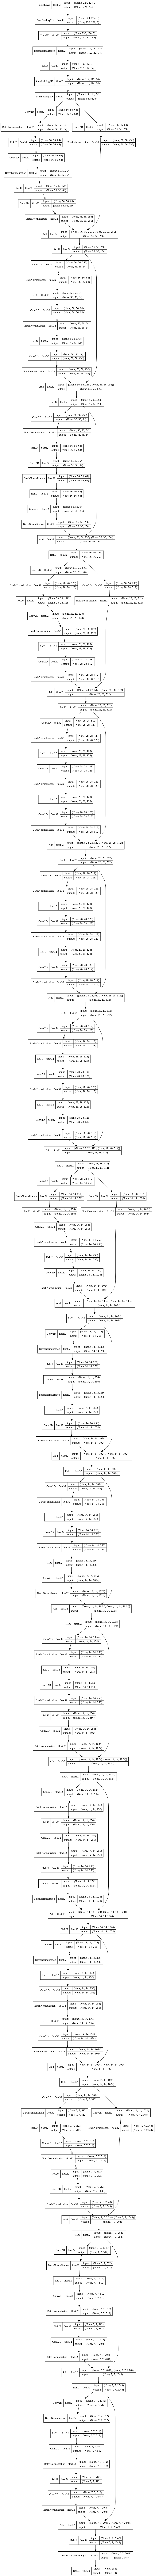

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, show_dtype=True)

# CIFAR10 전처리

## 데이터 로드 및 분할

In [ ]:
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

In [ ]:
(tr_im, tr_lb), (test_images, t_lb) = cifar10.load_data()

# 웟핫 인코딩
tr_oh_lb = to_categorical(tr_lb)
test_labels = to_categorical(t_lb)

# 훈련 세트 분할
train_images,  val_images , train_labels, val_labels = train_test_split(tr_im,tr_oh_lb, test_size=0.2 ,random_state = 403)


print(train_images.shape, train_labels.shape,val_images.shape, val_labels.shape,test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 7s 0us/step
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


## Sequence Dateset 생성

ram 부족해결 + albu 사용을 위해(배치단위 입력)

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import preprocess_input as dense_pr_input
class DataSet(Sequence): 
    def __init__(self, images_array, labels, batch_size, image_size=(256,256), augmentor=None, shuffle=False, pre_func =None):
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentor= augmentor
        self.pre_func = pre_func
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            self.on_epoch_end()
            pass

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        pre_im_batch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        image_batch = np.zeros((pre_im_batch.shape[0],self.image_size[0],self.image_size[1], 3), dtype='float32')

        for i in range(pre_im_batch.shape[0]):
            image = cv2.resize(pre_im_batch[i], self.image_size )

            if self.augmentor is not None:
                image = self.augmentor(image=image)['image'] 

            if self.pre_func is not None:
                for func in self.pre_func:
                    image = func(image)

            image = cv2.resize(image, self.image_size )

            image_batch[i] = image
                
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)



## 증강

In [ ]:
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2)

])

# fit 및 평가

In [ ]:
model.compile(optimizer=SGD(lr=0.01, momentum= 0.09,decay =0.0005 ), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_dataset = DataSet(train_images, train_labels, batch_size=64, augmentor=augmentor, shuffle=True, pre_func = [dense_pr_input])
val_dataset = DataSet(val_images, val_labels, batch_size=64, augmentor=None, shuffle=False, pre_func = [dense_pr_input])

In [ ]:
# 3번 validation error 가 개선되지 않으면 lr에 0.1곱함
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min', verbose=1)
# 3번 동안 개선이 없다면 조기종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [ ]:
history = model.fit(train_dataset, epochs=30, 
                    validation_data=val_dataset ,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/30
625/625 [==============================] - 551s 847ms/step - loss: 2.2036 - accuracy: 0.2262 - val_loss: 2.1011 - val_accuracy: 0.2657
Epoch 2/30
625/625 [==============================] - 531s 849ms/step - loss: 1.8150 - accuracy: 0.3194 - val_loss: 1.7628 - val_accuracy: 0.3637
Epoch 3/30
625/625 [==============================] - 531s 849ms/step - loss: 1.6886 - accuracy: 0.3661 - val_loss: 1.6849 - val_accuracy: 0.3698
Epoch 4/30
625/625 [==============================] - 531s 849ms/step - loss: 1.6105 - accuracy: 0.4072 - val_loss: 1.5374 - val_accuracy: 0.4377
Epoch 5/30
625/625 [==============================] - 531s 849ms/step - loss: 1.5511 - accuracy: 0.4229 - val_loss: 1.5702 - val_accuracy: 0.4349
Epoch 6/30
625/625 [==============================] - 531s 850ms/step - loss: 1.5049 - accuracy: 0.4421 - val_loss: 1.4343 - val_accuracy: 0.4686
Epoch 7/30
625/625 [==============================] - 531s 850ms/step - loss: 1.4661 - accuracy: 0.4631 - val_loss: 1.4698 -

In [ ]:
# 평가
test_dataset = DataSet(test_images, test_labels, batch_size=64, pre_func = [dense_pr_input])
print(model.evaluate(test_dataset))



157/157 [==============================] - 39s 251ms/step - loss: 1.0896 - accuracy: 0.6129
[1.0895615816116333, 0.6129000186920166]
